# Rossby wave Model with 5 modes
## This jupyter notebook test inverse problem with swath samples

#### First we calculate the Brunt-Vaisla frequency squared with a sample dataset.

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
state_ds = xr.open_dataset('../../Rossby_wave_test_case/MARA_RUN2_SWOT_state_2015-01-06.nc')
state_ds #.PHIHYD #, state_ds.DRHODR

<xarray.Dataset>
Dimensions:  (XC: 672, XG: 672, YC: 576, YG: 576, Zp1: 91, Z: 90, Zl: 90, Zu: 90)
Coordinates: (12/33)
  * XC       (XC) float32 230.0 230.0 230.1 230.1 ... 243.9 243.9 243.9 244.0
  * XG       (XG) float32 230.0 230.0 230.0 230.1 ... 243.9 243.9 243.9 244.0
    rA       (YC, XC) float32 ...
    dxG      (YG, XC) float32 ...
    dyG      (YC, XG) float32 ...
    Depth    (YC, XC) float32 ...
    ...       ...
  * Zl       (Zl) float32 0.0 -1.0 -2.14 ... -5.682e+03 -6.082e+03 -6.52e+03
    drF      (Z) float32 ...
    PHrefC   (Z) float32 ...
    rhoRef   (Z) float32 ...
    iter     int32 ...
    time     datetime64[ns] ...
Data variables:
    THETA    (Z, YC, XC) float32 ...
    SALT     (Z, YC, XC) float32 ...
    UVEL     (Z, YC, XG) float32 ...
    VVEL     (Z, YG, XC) float32 ...
    WVEL     (Zl, YC, XC) float32 ...
    PHIHYD   (Z, YC, XC) float32 ...
    DRHODR   (Zl, YC, XC) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/data/SO2/SWO...

In [4]:
LAT, LON = state_ds.YC.data, state_ds.XC.data

In [5]:
lat, lon = np.meshgrid(LAT, LON)

# Read Temperature, Salinity and Pressure data

In [6]:
temp = state_ds.THETA
salinity = state_ds.SALT
Z = state_ds.Z
pres_anomalies  =  state_ds.PHIHYD

# Calculate Brunt-Vaisla frequency squared

In [7]:
SA, CT = np.ma.masked_all(salinity.shape), np.ma.masked_all(temp.shape)
Nsquared = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
Pressure_mid = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
pres = np.ma.masked_all([salinity.shape[0],salinity.shape[1], salinity.shape[2]])
Z_mid = np.ma.masked_all([salinity.shape[0]-1, salinity.shape[1], salinity.shape[2]])
for y in range(SA.shape[1]):
    for x in range(SA.shape[2]):
        pres[:, y, x] = gsw.p_from_z(Z.data,  lat = LAT[y]) #+ pres_anomalies.data[:, y, x]
        SA[:, y, x] = gsw.conversions.SA_from_SP(salinity.data[:, y, x], pres.data[:, y, x], LON[x], LAT[y])
        CT[:, y, x] = gsw.CT_from_pt(SA.data[:, y, x], temp.data[:, y, x])  
        Nsquared[:, y, x], Pressure_mid[:, y, x] = gsw.stability.Nsquared(SA[:, y, x], CT[:, y, x], pres[:, y, x])
        Z_mid[:, y, x] = gsw.z_from_p(Pressure_mid[:, y, x] , lat = LAT[y])

In [8]:
xlon, ylat = np.meshgrid(LON, LAT)

In [9]:
zz, yy = np.meshgrid(Z[1:], LAT)

### Choose a vector at a random location

In [10]:
laty, lonx = 130, 220

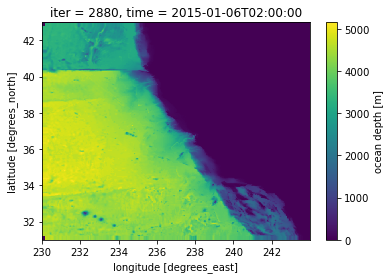

In [11]:
DEPTH = state_ds.Depth
DEPTH.plot()

## Interpolate the N2 vector onto a uniform pressure grid

In [12]:
N2_vector = Nsquared[:, laty, lonx]
Pmid_vector = Pressure_mid[:, laty, lonx]
#Pmid_vector, N2_vector
for i in range(len(N2_vector)-1):
    if N2_vector[i] < 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))
    if N2_vector[i] == 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))

In [13]:
Pmid_uniform = np.arange(Pmid_vector[0], Pmid_vector[-1], step = 120)
N2_uniform = np.interp(Pmid_uniform, Pmid_vector[:-2], N2_vector[:-2])

In [14]:
Pmid_uniform = Pmid_uniform[:]
N2_uniform = N2_uniform[:]
#Pmid_uniform[:-16], N2_uniform[:-16]

In [15]:
import VERT_FSFB3

In [16]:
c2, Psi, G, N2, Pmid = VERT_FSFB3.VERT_FSFB3(N2_uniform[:-16], Pmid_uniform[:-16])

In [17]:
g = 9.81 # gravity

## With a rigid lid assumpsion, SSH = Gm/g, where g is gravity, since hydrastatic pressure p = $rho * g *  SSH$

In [18]:
SSH = G/g

In [19]:
Z_mid_uniform  = gsw.z_from_p(np.append(0,Pmid), lat = laty)

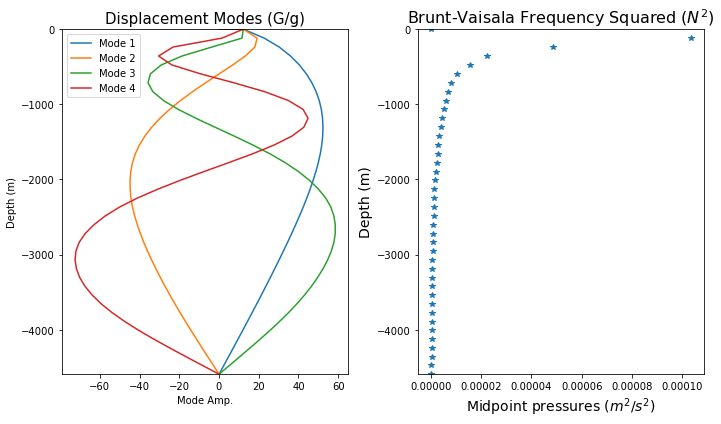

In [20]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(SSH[:,0], Z_mid_uniform, label = 'Mode 1')
plt.plot(SSH[:,1], Z_mid_uniform, label = 'Mode 2')
plt.plot(SSH[:,2], Z_mid_uniform, label = 'Mode 3')
plt.plot(SSH[:,3], Z_mid_uniform, label = 'Mode 4')
#plt.plot(SSH[:,4], Z_mid_uniform, label = 'Mode 5')
plt.xlabel('Mode Amp.')
plt.ylabel('Depth (m)')
#plt.xlim([-.2, .2])
plt.ylim([Z_mid_uniform.min(), 0])
plt.legend()
plt.title('Displacement Modes (G/g)', fontsize = 15)

plt.subplot(122)
plt.title('Brunt-Vaisala Frequency Squared ($N^2$)', fontsize = 16)
plt.plot(N2, Z_mid_uniform[1:], '*')
#plt.plot(Pmid_vector[:], N2_vector,  linewidth  = 2.0)
plt.xlabel('Midpoint pressures (${m^2}/{s^2}$)', fontsize = 14)
plt.ylabel('Depth (m)', fontsize = 14)
#plt.xlim([10, 350])
plt.ylim([Z_mid_uniform.min(), 0])

plt.tight_layout()
plt.savefig('vertical_modes_N2_sample_CCS_lon_' + str(lonx) + '_lat_' + str(laty) +'.png')

In [21]:
MODE = G.shape[-1]

In [22]:
Zgrid, mode = np.meshgrid(Z_mid_uniform, range(MODE) )

/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_13994/53837551.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_13994/53837551.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_13994/53837551.py:25: MatplotlibDeprec

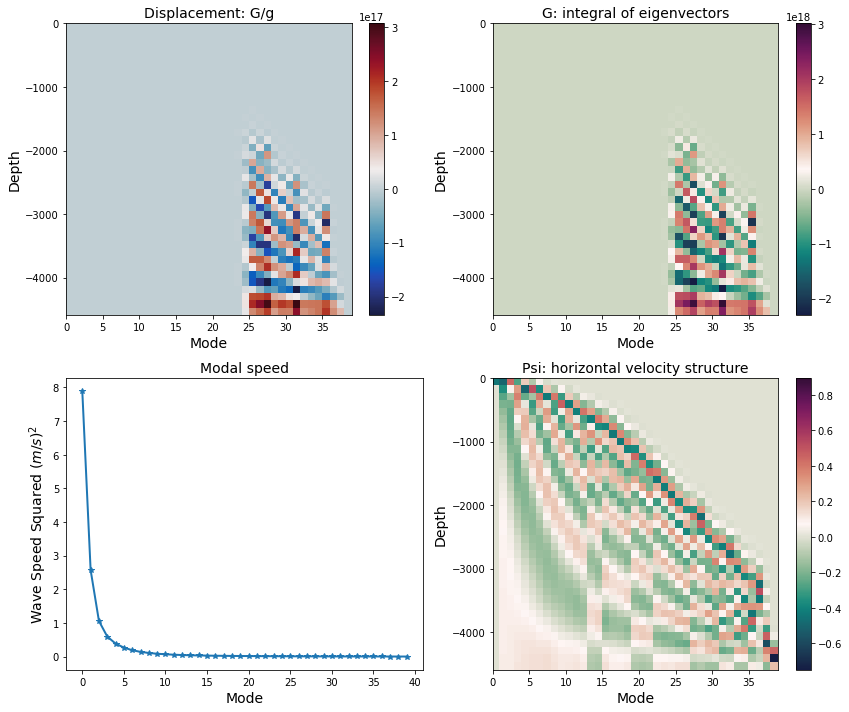

In [23]:
plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title('Displacement: G/g', fontsize = 14)
plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(222)
plt.title('G: integral of eigenvectors', fontsize = 14)
plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(223)
plt.title('Modal speed' , fontsize = 14)
plt.plot(c2[:], "-*", linewidth = 2)
plt.ylabel('Wave Speed Squared $(m/s)^2$', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
#plt.colorbar()

plt.subplot(224)
plt.title('Psi: horizontal velocity structure' , fontsize = 14)
plt.pcolor(mode, Zgrid, Psi[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.tight_layout()
plt.savefig('vertical_modes_FSFB2_N2_sample_lon_' + str(lonx) + '_lat_' + str(laty) +'.png', dpi = 100)

### Beta plane paramters

In [24]:
# wavespeed = # -c2[0]
Phi0 = 30 # central latitude (φ0)
Omega = 7.2921159e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
# Gradient of Coriolis parameter f = f0 + beta * (y-y0) 
# The constant β (the Rossby parameter) is given its value at a central latitude (φ0) on the spherical earth, 
# (2Ω cosφ0)/a, where Ω is the angular speed of the earth and a its mean radius. 
Beta

3.53106090197239e-12

## Choose a wave with 200-km wavelength that moves westward (negative wave speed). 

In [25]:
wavelength = 2e5 # 200km
wavespeed = c2 # m/s 
#np.sqrt(wavespeed) #,c2

## The dispersion relation relates frequency to wavenumber for each mode:

In [26]:
k_n = 2 * np.pi / wavelength # wavenumber
k_n

3.141592653589793e-05

## Rossby deformation radius Rm = c/f0 = 50.6 km, consistent with Chelton et al. (1998) https://ceoas.oregonstate.edu/rossby_radius

In [27]:
Rm = wavespeed / f0
Rm[0]/1000, f0

(-54.73026096765938, -0.00014409682231500762)

In [28]:
F_modes = 5

## SSH Five Baroclinic mode

### Amplitude matrix

In [29]:
Amp = np.array([[.5, .4, .3, .2, .1], [.5, .4, .3, .2, .1]])
Amp.shape

(2, 5)

In [30]:
freq_n = (Beta * k_n) / (k_n ** 2  + Rm[:Amp.shape[1]] ** -2)
freq_n

array([8.39878009e-08, 2.68846601e-08, 5.66934577e-09, 1.85702449e-09,
       7.85974319e-10])

In [107]:
wavelength_l = .5 * wavelength
l_n = 2 * np.pi / wavelength_l # wavenumber
l_n, k_n, wavelength, wavelength_l

(6.283185307179586e-05, 3.141592653589793e-05, 200000.0, 100000.0)

### Expand SSH to 2-dimensional space - SSH(x, y, t)

In [108]:
Rm = wavespeed / f0
Rm[:Amp.shape[1]]/1000, f0

(array([-54.73026097, -17.84791968,  -7.33631201,  -4.12571238,
         -2.67116334]),
 -0.00014409682231500762)

In [109]:
freq_n = (Beta * k_n) / (k_n ** 2 + l_n ** 2 + Rm[:Amp.shape[1]] ** -2)
freq_n

array([2.10550345e-08, 1.37392795e-08, 4.71753114e-09, 1.74190553e-09,
       7.64587787e-10])

In [110]:
X_loc = np.arange(0, 1e6, 1e4)
Y_loc = np.arange(0, 1e6, 1e4)
T_time = np.arange(0, 1e8, 1e6)

In [111]:
snapshot = 21
M =  Amp.size

In [168]:
points_x = np.arange(30, 50)
points_y = np.repeat(50, len(points_x))
points_x, points_y

(array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49]),
 array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50]))

### Elements of H Matrix

In [169]:
%%time
H_cos = np.ma.masked_all([Amp.shape[1], len(T_time), len(X_loc), len(Y_loc)]) # Number of waves * Number of data
H_sin = np.ma.masked_all([Amp.shape[1], len(T_time), len(X_loc), len(Y_loc)])
for mm in range(Amp.shape[1]):
    #print(Psi[0, mm], freq_n[mm], Rm[mm])
    H_cos[mm] = Psi[0, mm] * np.cos(k_n * X_loc + l_n*Y_loc + freq_n[mm]*T_time) 
    H_sin[mm] = Psi[0, mm] * np.sin(k_n * X_loc + l_n*Y_loc + freq_n[mm]*T_time)
#H_cos = H_cos.reshape(Amp.shape[1], len(T_time) * len(X_loc)*len(Y_loc))
#H_sin = H_sin.reshape(Amp.shape[1], len(T_time) * len(X_loc)*len(Y_loc))

CPU times: user 11.8 ms, sys: 2.56 ms, total: 14.3 ms
Wall time: 14.2 ms


In [170]:
%%time
SSH_XYT = np.zeros([Amp.shape[1], len(T_time) , len(X_loc), len(Y_loc)])
for mm in range(Amp.shape[1]):
    SSH_XYT[mm] = Amp[0, mm] * H_cos[mm] + Amp[1, mm] * H_sin[mm]

CPU times: user 36.5 ms, sys: 4.85 ms, total: 41.4 ms
Wall time: 38.7 ms


#### Add up long the last two axis: modes, frequences

In [171]:
SSH_XY = np.sum(SSH_XYT, axis = 0)
SSH_XY.shape

(100, 100, 100)

### Select y samples

In [172]:
y_glider = SSH_XY[snapshot, points_x, points_y]

In [173]:
M, N =  Amp.size, len(y_glider)
M, N, 

(10, 20)

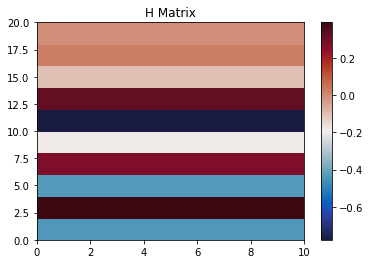

In [174]:
H_ = np.ma.masked_all([2, Amp.shape[1], len(T_time), len(X_loc), len(Y_loc)])
H_[0], H_[1] = H_cos, H_sin
H_matrix = H_[:, :, snapshot, points_x, points_y].data.reshape(N, M)
plt.pcolor(H_matrix, cmap = cmo.cm.balance)
plt.title('H Matrix')
plt.colorbar()

In [175]:
H_[:, :, snapshot, points_x, points_y].data.shape

(2, 5, 20)

In [146]:
#ds_output = xr.Dataset(data_vars={'SSH' : (('time', 'x', 'y', 'mode', 'len(freq)'), SSH_XYT),
#                                  'amplitude': (('amp2', 'mode'), Amp),
#                                  'H_matrix': (('time', 'x', 'y',  'len(sin_cos)', 'mode', 'len(freq)'), H_),
#                                  'time' : (('time'), T_time),
#                                  'x' : (('x'), X_loc),
#                                  'y': (('y'), Y_loc),
#                                  'Psi':(('mode'), Psi[0, :5])},
#                      attrs = dict(description=('Rossby wave SSH(x, y, t) with 5 baroclinic modes, Amp = np.array([[.5, .4, .3, .2, .1], [.5, .4, .3, .2, .1]])')))
#ds_output.to_netcdf('./Rossby_wave_5_modes_XYTM.nc')

### Batch plot and make movie

In [147]:
#for tt in range(100):
    #plt.figure(figsize = (12, 9))
    #plt.pcolor( X_loc/1e3, Y_loc/1e3, SSH_XY[tt], cmap = cmo.cm.balance, vmin = -1., vmax = 1. )
    #plt.xlabel('Distance(km)')
    #plt.ylabel('Distance(km)')
    #plt.title('Time ' + str(tt/1e6) + ' 1e6 seconds')
    #plt.colorbar()
    #plt.savefig('./SSH_XYT_5modes/SSH_XYT_' + str(T_time[tt]/1e6).zfill(4) + '.png')
    #plt.close()

In [148]:
def make_gif(*, pic_path, gif_path):
    
    '''
    pic_path: full path and name of picture input(eg.:'./adv_ml_05d/adv_ml*.png')
    gif_path: full path an name if the gif output(eg.:'./adv_ml_05d.gif')
    '''
    
    import imageio
    import glob
    
    images = []
    imagenames = sorted(glob.glob(pic_path))
    for filename in imagenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(gif_path, images)

In [149]:
#make_gif(pic_path = './SSH_XYT_5modes/SSH_XYT_*.png', gif_path='./SSH_XYT_5modes.gif')

In [154]:
SSH_XY.shape

(100, 100, 100)

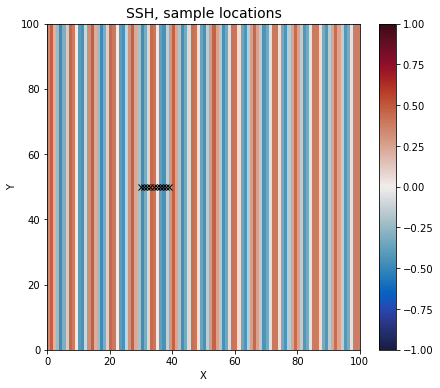

In [152]:
fig = plt.figure(figsize = (7, 6))
plt.pcolor(SSH_XY[0],cmap = cmo.cm.balance, vmin = -1, vmax = 1)
plt.title('SSH, sample locations', fontsize = 14)
plt.plot(points_x, points_y, 'x', color = 'black')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()

#### Ordinary Least Squares (OLS) Solution
#### The solution is $X_{OLS} = (H^TH)^{-1}H^Ty$
#### Solution: Amp = np.array([[.5, .4, .3, .2, .1], [.5, .4, .3, .2, .1]])

In [103]:
H_inv = LA.inv(np.matmul(H_matrix.T, H_matrix))

In [104]:
X_OLS = np.matmul(np.matmul(H_inv, H_matrix.T), y_glider)

In [105]:
np.matmul(H_inv, H_matrix.T).shape, y_glider.shape

((10, 10), (10,))

In [106]:
X_OLS #.reshape(2, 5) 

array([-1.50966268e+16, -1.00644179e+16,  7.86473216e+15, -1.19153592e+16,
        0.00000000e+00,  8.05153430e+16,  2.01288358e+16, -1.61030686e+17,
        0.00000000e+00,  0.00000000e+00])

### Weighted least square solution

In [67]:
num_samples = len(T_time)
noise_std = 0.002

In [68]:
white_noise = np.random.normal(0, noise_std, size = num_samples)

In [69]:
SSH_WN = np.ma.masked_all(SSH_XY.shape)
white_noise_x, white_noise_y = np.ma.masked_all(SSH_XY.shape), np.ma.masked_all(SSH_XY.shape)
for tt in range(len(T_time)):
    for yy in range(len(Y_loc)):
        white_noise_y[tt, yy] = np.random.normal(0, noise_std, size = num_samples)
        SSH_WN[tt, yy] = SSH_XY[tt, yy]  + white_noise_y[tt, yy]

In [70]:
y_swath = SSH_WN[snapshot, points_x, points_y]

In [71]:
y_swath.shape

(10,)

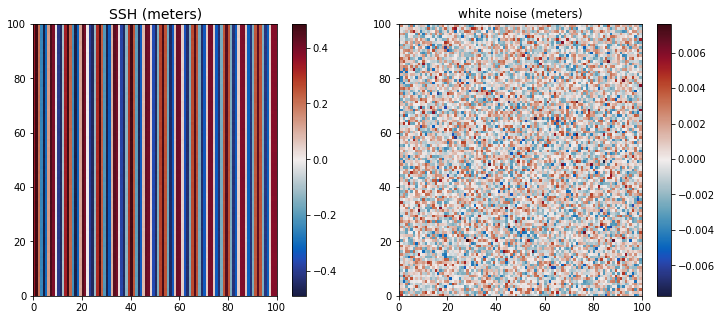

In [72]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.pcolor(SSH_WN[0],cmap = cmo.cm.balance, )
plt.title('SSH (meters)', fontsize = 14)
plt.colorbar()

plt.subplot(122)
plt.pcolor(white_noise_y[0],cmap = cmo.cm.balance,)
plt.title('white noise (meters)')
plt.colorbar()
plt.savefig('./SSH_white_noise.png')

### Residual: processes that are not considered "signals" in this analysis, here we dictate the standard deviation to be the redidual first

### Elements of H

In [73]:
residual = y_swath.std() # = n * sigma **2

In [74]:
residual

0.0021902094094361593

#### R Matrix

In [75]:
R_ = np.eye(N, N)

In [76]:
for ii in range(N):
    R_[ii, ii] = (residual * 0.7) ** 2 #. half of the variance is noise
#R_

#### P matrix =0 For now

In [77]:
A = np.matmul(H_matrix.T, LA.inv(R_))

In [78]:
B = np.matmul(A, H_matrix)

In [ ]:
D = np.matmul(np.matmul(LA.inv(B), H_matrix.T) , LA.inv(R_))

In [ ]:
X_ = np.matmul(D, y_glider)

In [ ]:
X_ #eq.7

#### Amp = np.array([[.5, .4, .3, .2, .1], [.5, .4, .3, .2, .1]])

In [ ]:
C = np.matmul(H_matrix.T, H_matrix) # No noise setup

In [ ]:
X_no_noise = np.matmul(np.matmul(LA.inv(C) , H_matrix.T) , y_swath) # assume no noise

In [ ]:
X_no_noise#.reshape(2, 5)